In [1]:
import torch #PyTorch import
from torch import nn,functional,optim #Essentials for model
from torch.nn.functional import leaky_relu

from torchvision import transforms as tfs, datasets as dts #Import for using MNIST dataset and transforming data
from torch.utils.data import DataLoader #Loading datasets

import matplotlib.pyplot as plt #Plotting results and data

In [2]:
batch_size = 64 #Size for batches of data loaded in the DataLoader

leaky_relu_slope_1 = 0.01 #Slope for negative values of leakyReLU
leaky_relu_slope_2 = 0.01 #Slope for negative values of leakyReLU

adam_lr = 0.03 #Adam optimizer hyperparameter

In [3]:
transform = tfs.Compose([tfs.ToTensor(),
                       tfs.Normalize((0.5),(0.5))])

In [4]:
trainset = dts.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
testset = dts.MNIST('./MNIST_data/', download=True, train=False, transform=transform)

In [5]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden_layer_1 = nn.Linear(28 * 28, 128)
        self.hidden_layer_2 = nn.Linear(128, 64)
        
        self.output_layer = nn.Linear(64, 10)
    
    def forward(self, input):
        input = leaky_relu(self.hidden_layer_1(input), leaky_relu_slope_1)
        input = leaky_relu(self.hidden_layer_2(input), leaky_relu_slope_2)
        
        output = self.output_layer(input)
        return output

model = Network()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=adam_lr)

In [8]:
epochs = 15
train_losses, test_losses = [] ,[]

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0],-1)
        
        optimizer.zero_grad()
        
        predictions = model(images)
        
        loss = criterion(predictions, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for images,labels in testloader:
                images = images.view(images.shape[0],-1)
                
                test_predictions = model(images)
                test_loss += criterion(test_predictions, labels)
                
                ps = torch.exp(test_predictions)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15..  Training Loss: 0.686..  Test Loss: 0.353..  Test Accuracy: 0.899
Epoch: 2/15..  Training Loss: 0.395..  Test Loss: 0.326..  Test Accuracy: 0.909
Epoch: 3/15..  Training Loss: 0.356..  Test Loss: 0.346..  Test Accuracy: 0.900
Epoch: 4/15..  Training Loss: 0.385..  Test Loss: 0.324..  Test Accuracy: 0.915
Epoch: 5/15..  Training Loss: 0.427..  Test Loss: 0.319..  Test Accuracy: 0.914
Epoch: 6/15..  Training Loss: 0.374..  Test Loss: 0.382..  Test Accuracy: 0.892
Epoch: 7/15..  Training Loss: 0.423..  Test Loss: 0.670..  Test Accuracy: 0.844
Epoch: 8/15..  Training Loss: 0.716..  Test Loss: 0.507..  Test Accuracy: 0.905
Epoch: 9/15..  Training Loss: 0.572..  Test Loss: 0.327..  Test Accuracy: 0.926
Epoch: 10/15..  Training Loss: 0.432..  Test Loss: 0.943..  Test Accuracy: 0.870
Epoch: 11/15..  Training Loss: 0.463..  Test Loss: 0.353..  Test Accuracy: 0.914
Epoch: 12/15..  Training Loss: 0.594..  Test Loss: 0.564..  Test Accuracy: 0.875
Epoch: 13/15..  Training Loss: 0.394.

In [37]:
img, lbl = next(iter(testloader))

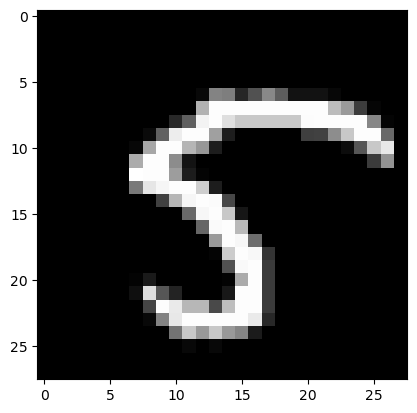

In [38]:
img_plt = img.squeeze()
plt.imshow(img_plt[0], cmap='gray')

In [39]:
img = img.view(img.shape[0], -1)

print(torch.exp(model(img[0])).topk(1,dim=0)[1][0])

tensor(5)
